In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## This notebook deals with stage-discharge (plotting) and stage residuals (calculating and plotting). + Time series plots of residuals.
Data to be used for original discharde and height is in "field_measurements.csv file", which was web scraped in "field_measurements.ipynb" document, and compiled into one .csv file in field_measurement_data/combine data.ipynb.
Data from rating curves is in "rating_curve_wa.csv".
Data labeled as valid/invalid is in "CA_valid_gages.csv".


Functions and purpose:
* Plot the stage-discharge data from field measurements with corresponding rating curves.
* Obtain and plot stage residuals (for valid and possibly valid gauges).
* Residual time series plots (for valid and possibly valid gauges).

### Data inputs and preprocessing

In [2]:
field_measurements = pd.read_csv("field_measurements.csv", encoding='latin-1', low_memory=False)
field_measurements

,Unnamed: 0,agency_cd,site_no,measurement_nu,measurement_dt,tz_cd,q_meas_used_fg,party_nm,site_visit_coll_agency_cd,gage_height_va,...,chan_area,chan_velocity,chan_stability,chan_material,chan_evenness,long_vel_desc,horz_vel_desc,vert_vel_desc,chan_loc_cd,chan_loc_dist
0,0,USGS,11149400,1,1958-01-08,NaN,Yes,EIS,USGS,5.03,...,158.00,1.63,UNSP,UNSP,UNSP,unkn,UNSP,UNSP,UNSP,NaN
1,1,USGS,11149400,2,1958-01-08,NaN,Yes,EIS,USGS,5.22,...,180.00,1.72,UNSP,UNSP,UNSP,unkn,UNSP,UNSP,UNSP,NaN
2,2,USGS,11149400,3,1958-01-09,NaN,Yes,EIS,USGS,5.66,...,306.00,1.57,UNSP,UNSP,UNSP,unkn,UNSP,UNSP,UNSP,NaN
3,3,USGS,11149400,4,1958-01-09,NaN,Yes,EIS,USGS,5.71,...,311.00,1.57,UNSP,UNSP,UNSP,unkn,UNSP,UNSP,UNSP,NaN
4,4,USGS,11149400,5,1958-01-09,NaN,Yes,EIS,USGS,5.79,...,326.00,1.58,UNSP,UNSP,UNSP,unkn,UNSP,UNSP,UNSP,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135663,135663,USGS,10343500,703,2022-08-17 11:40:55,PDT,Yes,JNAWIKA,USGS,1.50,...,3.10,0.46,FIRM,GRVL,UNEV,STDY,UNEV,STND,UPST,50.0
135664,135664,USGS,10343500,704,2022-10-04 11:14:37,PDT,Yes,YMOJICAPEREZ,USGS,1.49,...,4.48,0.32,FIRM,SAND,EVEN,STDY,EVEN,STND,UPST,65.0
135665,135665,USGS,10343500,705,2022-10-04 12:01:29,PDT,Yes,YMOJICAPEREZ,USGS,1.49,...,3.98,0.39,FIRM,SAND,EVEN,STDY,EVEN,STND,UPST,66.0
135666,135666,USGS,10343500,706,2022-11-22 11:10:29,PST,Yes,JNAWIKA,USGS,1.53,...,3.38,0.54,FIRM,GRVL,UNEV,STDY,UNEV,STND,UPST,100.0


In [3]:
field_measurements["measurement_dt"] = pd.to_datetime(field_measurements["measurement_dt"])

In [4]:
sites = field_measurements['site_no'].unique() #array of the gauge numbers
field_measurements['site_no'].nunique() #amount of available gauges

158

In [5]:
#Input data with all rating curves and create a dataframe
curve = pd.read_csv('rating_curve_wa.csv', encoding='latin-1', low_memory=False)
curve

,Site No,INDEP,SHIFT,DEP,STOR
0,10260500,0.79,-0.23,0.01,NaN
1,10260500,0.80,-0.23,0.02,NaN
2,10260500,0.81,-0.23,0.04,NaN
3,10260500,0.82,-0.23,0.05,NaN
4,10260500,0.83,-0.23,0.07,NaN
...,...,...,...,...,...
162451,11525500,24.45,0.00,21033.14,NaN
162452,11525500,24.46,0.00,21065.17,NaN
162453,11525500,24.47,0.00,21097.21,NaN
162454,11525500,24.48,0.00,21129.28,*


In [6]:
#Input all CA gauges' water summaries with valid/invalid labels obtained with the ML model
labeled_gages = pd.read_csv('CA_valid_gages.csv', encoding='latin-1', low_memory=False)
labeled_gages

,Site No,Location,Gage,Remarks,Full Text,Valid
0,9429600,lat long referenced to...,water stage recorder datum of gage is ...,record rated fair natural flow colorado river ...,lat long referenced to...,0
1,9521100,lat long referenced to...,water stage recorder datum of gage is ...,records are rated good natural flow stream aff...,lat long referenced to...,0
2,9523000,lat long referenced to...,a water stage recorder,record rated good all american canal diverts w...,lat long referenced to...,0
3,9530000,lat long referenced to...,acoustic doppler velocity meter radar stage s...,record rated poor owing to unstable channel co...,lat long referenced to...,0
4,10260500,lat long referenced to...,water stage recorder broad crested weir since...,slight regulation by lake arrowhead capacity a...,lat long referenced to...,0
...,...,...,...,...,...,...
108,11478500,lat long referenced to...,water stage recorder and crest stage gage dat...,no storage or large diversion upstream station...,lat long referenced to...,2
109,11481000,lat long referenced to...,water stage recorder and crest stage gage dat...,flow regulated by ruth reservoir station mi up...,lat long referenced to...,0
110,11481200,lat long referenced to...,water stage recorder and crest stage gage dat...,no storage or diversion upstream station,lat long referenced to...,2
111,11482500,lat long referenced to...,water stage recorder and crest stage gage dat...,no regulation or diversion upstream station,lat long referenced to...,2


In [7]:
#Check amounts of valid/invalid labels
# 0 = invalid; 1 = "maybe" / possible gauge; 2 = valid
labeled_gages["Valid"].value_counts()

0    87
2    13
1    13
Name: Valid, dtype: int64

In [8]:
#Get subsets of data with gauges labeled 2 and 1
gage_valid = labeled_gages.loc[(labeled_gages['Valid'] == 2)]
gage_maybe = labeled_gages.loc[(labeled_gages['Valid'] == 1)]

#Check whether the gauges have corresponding rating curve data (boolean)
valid_curves = gage_valid["Site No"].isin(curve["Site No"])
maybe_curves = gage_maybe["Site No"].isin(curve["Site No"])

In [9]:
#Get arrays with gauges numbers that have corresponding rating curves

valid_siteno = gage_valid["Site No"].unique()
valid_siteno = gage_valid.loc[valid_curves, "Site No"].unique()

maybe_siteno = gage_maybe["Site No"].unique()
maybe_siteno = gage_maybe.loc[maybe_curves, "Site No"].unique()

### Plot the stage-discharge data with rating curves

In [11]:
'''
    Axis are log scaled since there is inconsistency in discharge (some gauges have very large discharge).
    This code does not show the plots in the notebook, because there are 158 gauges available,
all the plots are saved in Rating curves folder instead. To see plots here, uncomment plt.show() at the end of the code.
'''


for site_no in sites:
#for site_no in valid_siteno: #uncomment this line to plot ONLY the valid gauges; replace with maybe_siteno for "maybe" gauges; comment line above
        site_df = field_measurements.loc[field_measurements['site_no'] == site_no]
        curve_df = curve.loc[curve['Site No'] == site_no]

        site_df.dropna(subset=["discharge_va", "gage_height_va"])
        curve_df.dropna(subset=["INDEP", "DEP"])

        fig, ax = plt.subplots(figsize=(10.24, 7.68))

        sns.scatterplot(data = site_df, x = "discharge_va", y = "gage_height_va", color = 'steelblue')
        plt.plot(curve_df["DEP"], curve_df["INDEP"], 'tomato')

        plt.xscale('log')
        plt.yscale('log')
        plt.title('Site: ' + str(site_no))
        plt.xlabel('Discharge (in cfs)')
        plt.ylabel('Stage (in ft)')

        fig.savefig(f'Rating curves/{site_no}.jpg', dpi=300)
        #plt.show()
        plt.close()

### Obtain and plot stage residuals

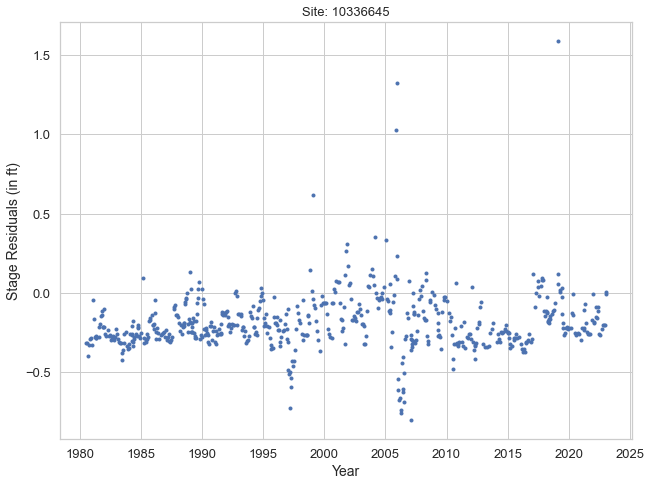

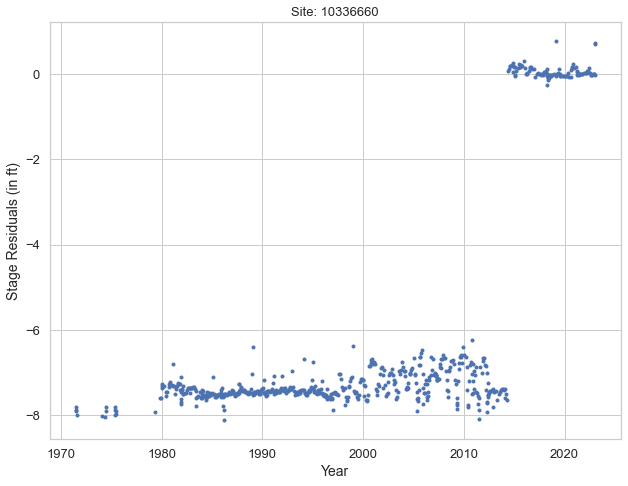

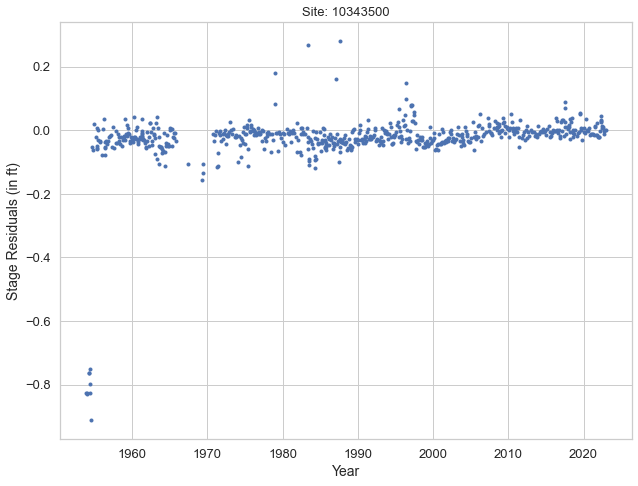

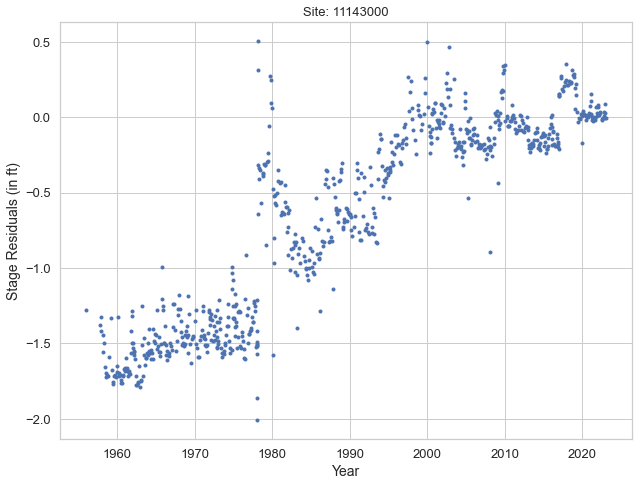

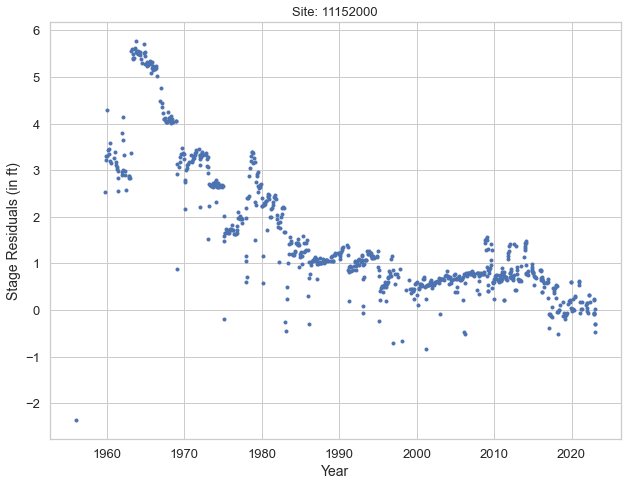

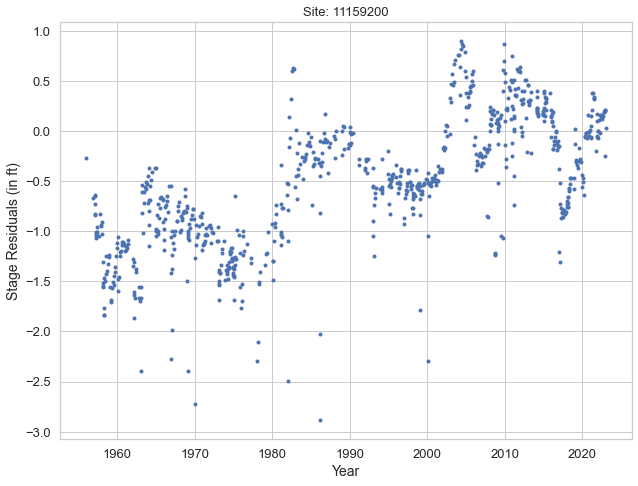

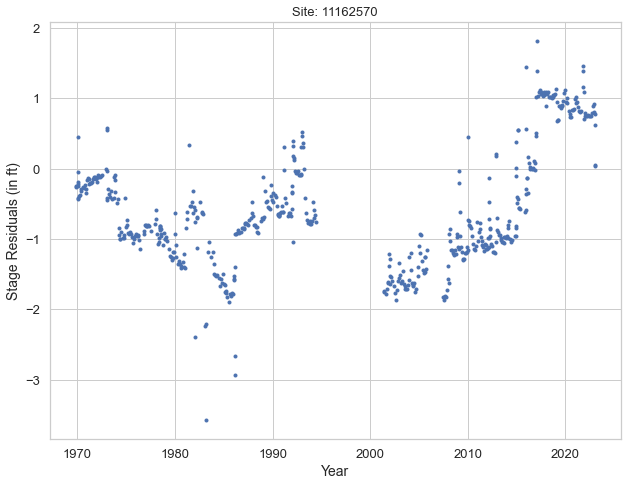

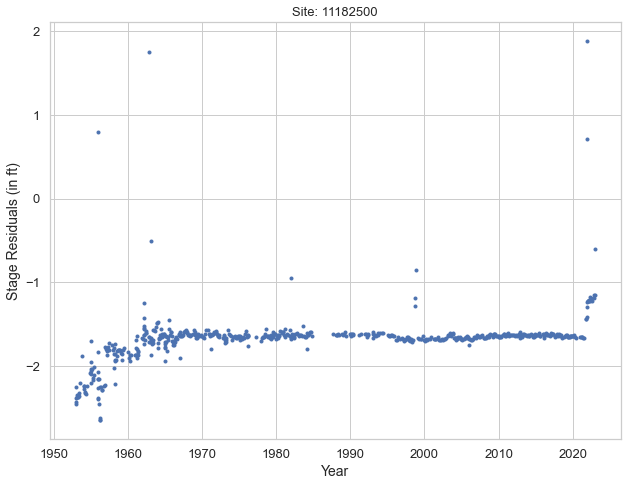

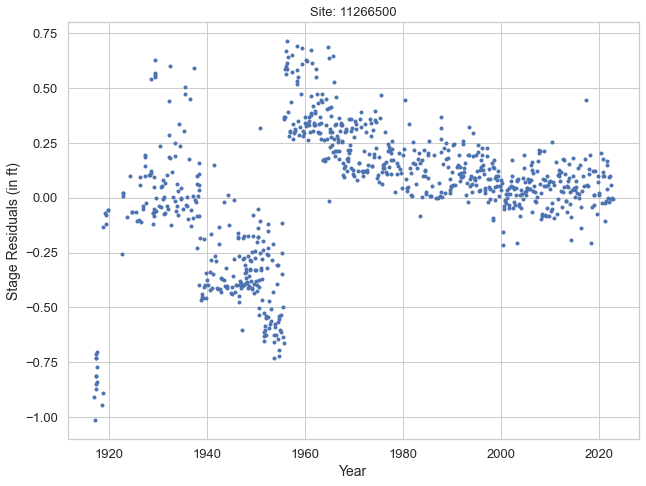

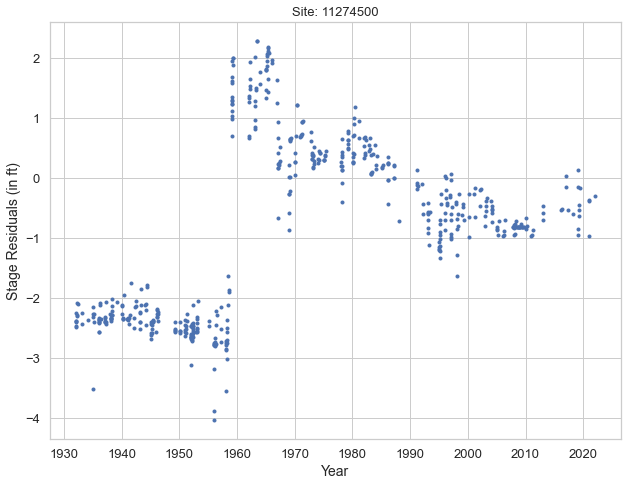

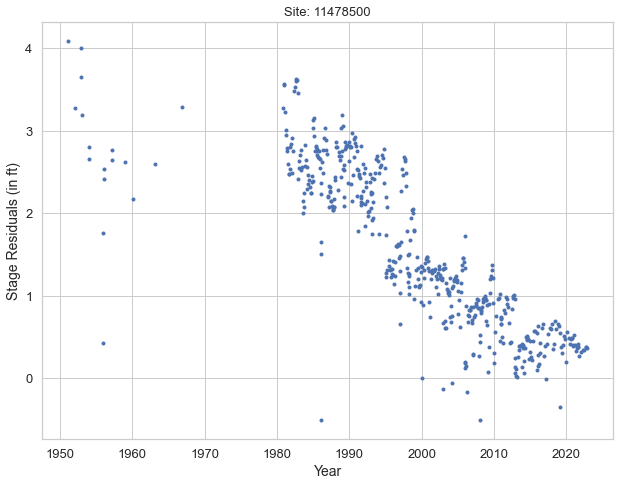

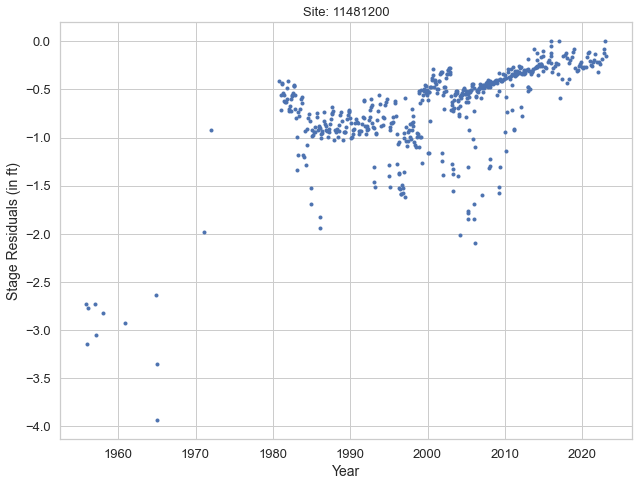

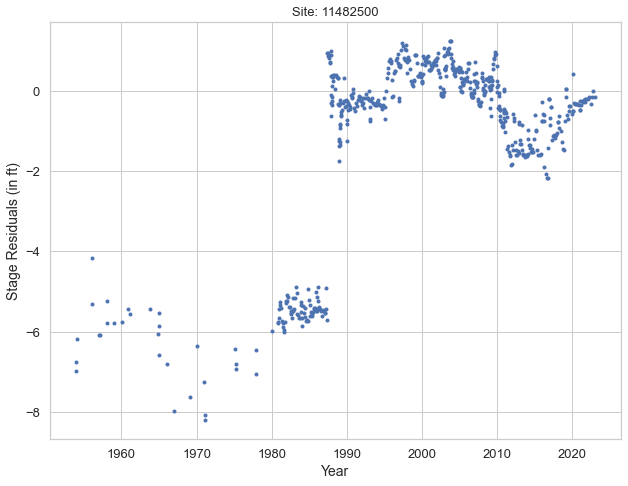

In [10]:
'''
    This code calculates stage residuals of the observations in valid gauges
and plots them in a separate plot for each gauge.
    In each iteration of the for loop we take a subset of data correspondig to the gauge number,
select observations with monotonically increasing discharge values and use them for interpolation;
find residuals (height of the gauge from field measurements - interpolated height from the rating curve data).
    Plot each gauge in its' own plot. Save the images in "Stage Residuals" folder. Name of the image = gauge number.
'''
sns.set_theme(style="whitegrid") #may comment this line if grid is not needed on the plots

for site_no in valid_siteno:
    
        #Create subsets of data for each gauge and drop Na's
        site_df = field_measurements.loc[field_measurements['site_no'] == site_no]
        curve_df = curve.loc[curve['Site No'] == site_no]
        site_df.dropna(subset=["discharge_va", "gage_height_va"])
        curve_df.dropna(subset=["INDEP", "DEP"])

        fig, ax = plt.subplots(figsize=(10.24, 7.68))

        stage_rating = curve_df["INDEP"].to_numpy()
        Q_rating = curve_df["DEP"].to_numpy()

        # Create boolean mask for increasing Q_rating
        q_diff = np.diff(Q_rating)
        q_mask = np.insert(q_diff, 0, Q_rating[0]) > 0

        # Filter arrays using boolean mask
        stage_rating_monot = stage_rating[q_mask]
        Q_rating_monot = Q_rating[q_mask] #predicted discharge (monotonically increasing)

        Q = site_df["discharge_va"].to_numpy() #original discharge
        h_gage = site_df["gage_height_va"].to_numpy()

        #Interpolate rating curve's height and calculate residuals
        stage_rating_interp = np.interp(Q, Q_rating_monot, stage_rating_monot)
        stage_residual = h_gage - stage_rating_interp

        plt.plot(site_df["measurement_dt"], stage_residual, ".")

        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.title('Site: ' + str(site_no), fontsize=13)
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('Stage Residuals (in ft)', fontsize=14)
        
        plt.show()

        fig.savefig(f'Stage residuals/{site_no}.jpg', dpi=300)
        plt.close()

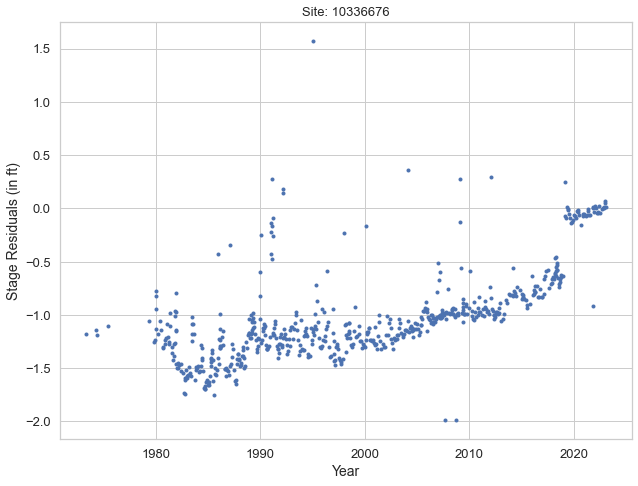

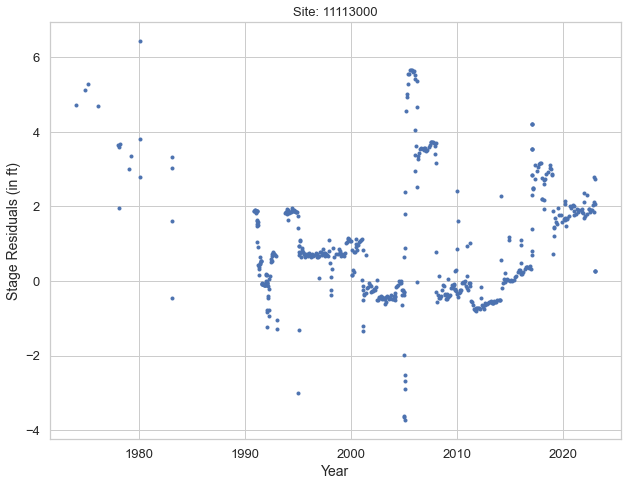

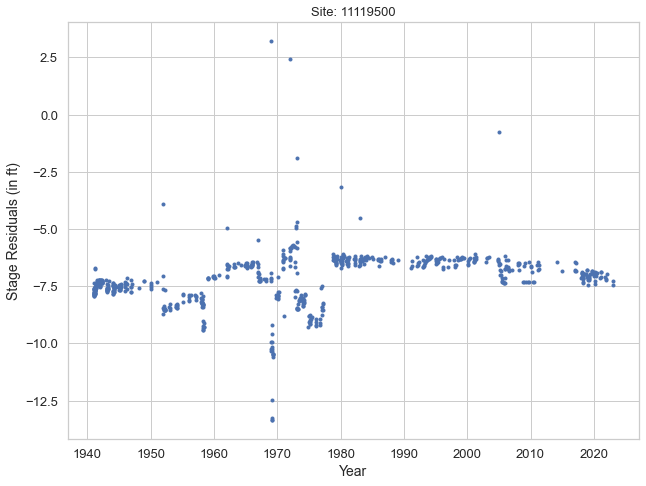

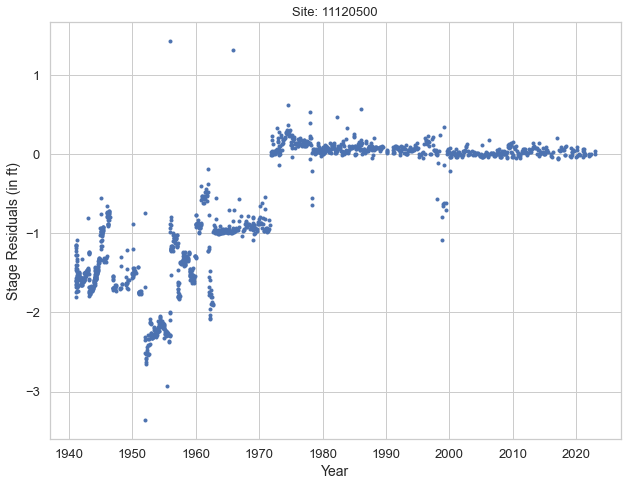

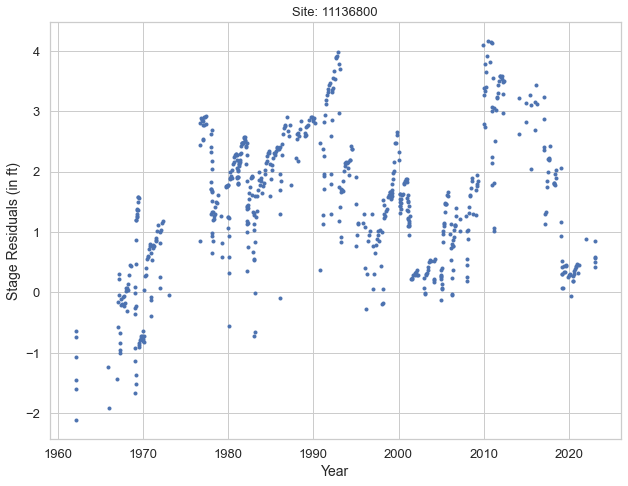

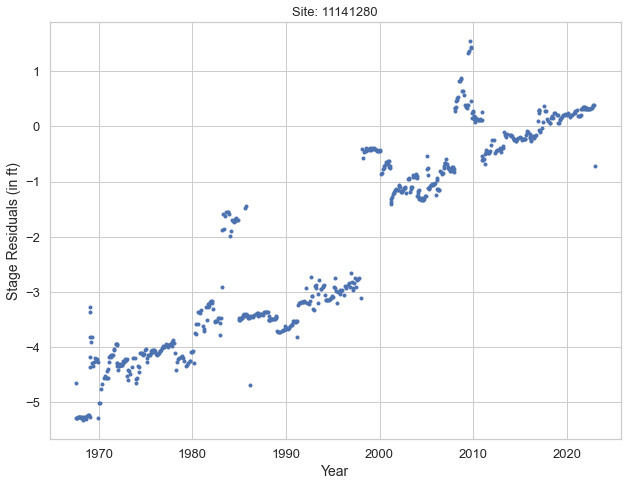

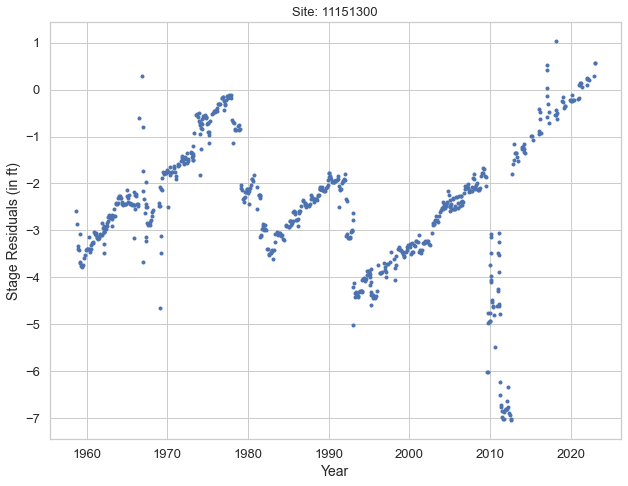

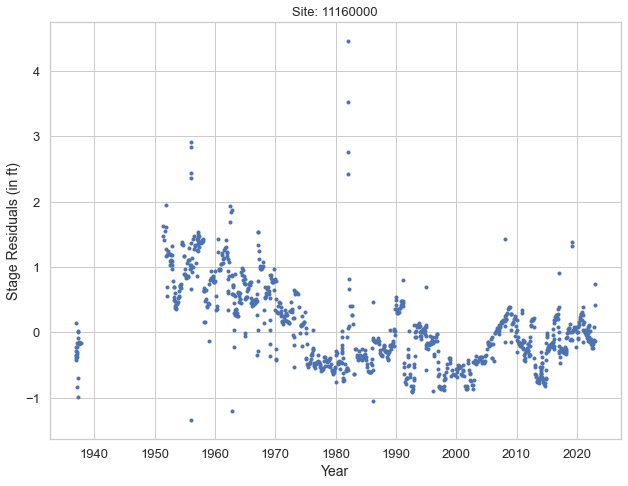

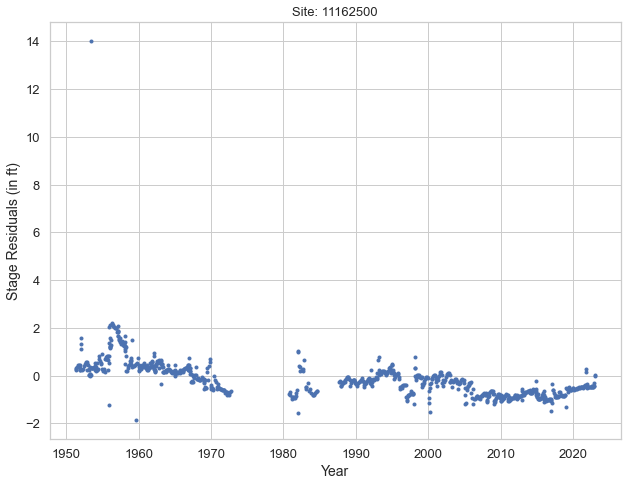

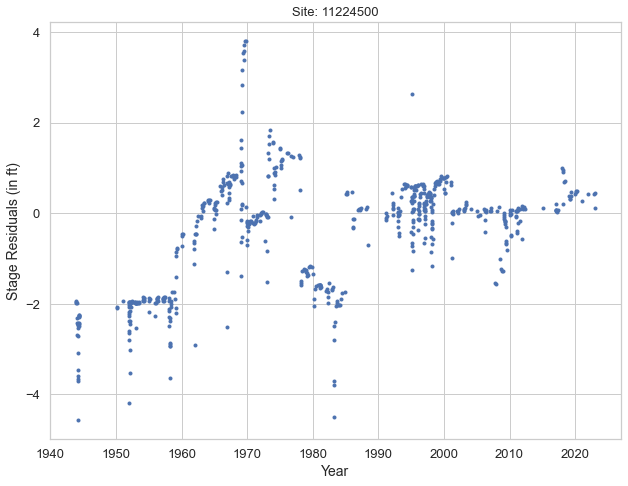

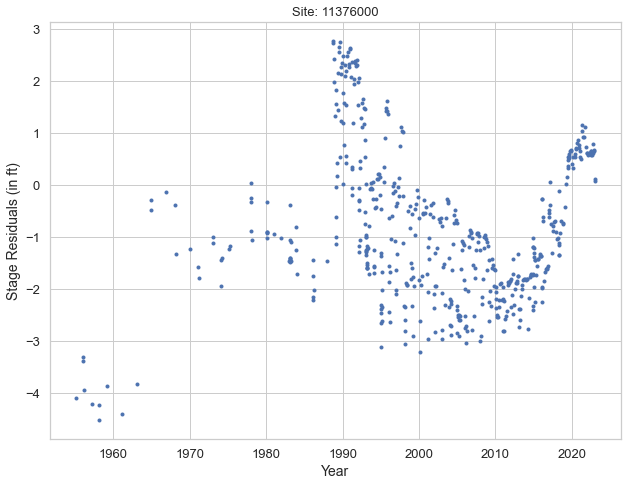

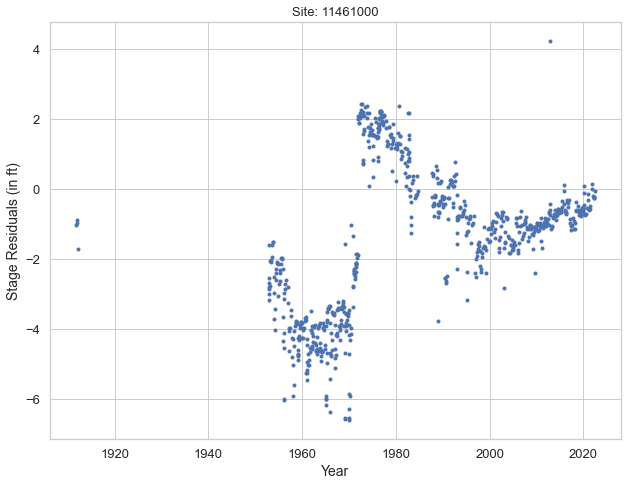

In [11]:
'''
    This code calculates stage residuals of the observations in "maybe" gauges
and plots them in a separate plot for each gauge, similarly to the code above for valid gauges.
    Save the images in "MB Stage residuals" folder. Name of the image = gauge number.
'''
sns.set_theme(style="whitegrid") #may comment this line if grid is not needed on the plots

for site_no in maybe_siteno:
    
        #Create subsets of data for each gauge and drop Na's
        site_df = field_measurements.loc[field_measurements['site_no'] == site_no]
        curve_df = curve.loc[curve['Site No'] == site_no]
        site_df.dropna(subset=["discharge_va", "gage_height_va"])
        curve_df.dropna(subset=["INDEP", "DEP"])

        fig, ax = plt.subplots(figsize=(10.24, 7.68))

        stage_rating = curve_df["INDEP"].to_numpy()
        Q_rating = curve_df["DEP"].to_numpy()

        # Create boolean mask for increasing Q_rating
        q_diff = np.diff(Q_rating)
        q_mask = np.insert(q_diff, 0, Q_rating[0]) > 0

        # Filter arrays using boolean mask
        stage_rating_monot = stage_rating[q_mask]
        Q_rating_monot = Q_rating[q_mask]

        Q = site_df["discharge_va"].to_numpy()
        h_gage = site_df["gage_height_va"].to_numpy()
        
        #Interpolate rating curve's height and calculate residuals
        stage_rating_interp = np.interp(Q, Q_rating_monot, stage_rating_monot)
        stage_residual = h_gage - stage_rating_interp

        plt.plot(site_df["measurement_dt"], stage_residual, ".")

        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.title('Site: ' + str(site_no), fontsize=13)
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('Stage Residuals (in ft)', fontsize=14)
        
        plt.show()

        fig.savefig(f'MB Stage residuals/{site_no}.jpg', dpi=300)
        plt.close()

### Residual time series plots

The ouput of the following code is a plot made of stacked and appropriately sized mini-plots of the time series for each gauge. If needed, each gauge's plot can be modified to add a new feature, for example, a measurement line that was added to this plot to be displayed at the first gauge only.
Residual time series.jpg and Residual time series (maybe gauges).jpg can be found in the same directory as this notebook.

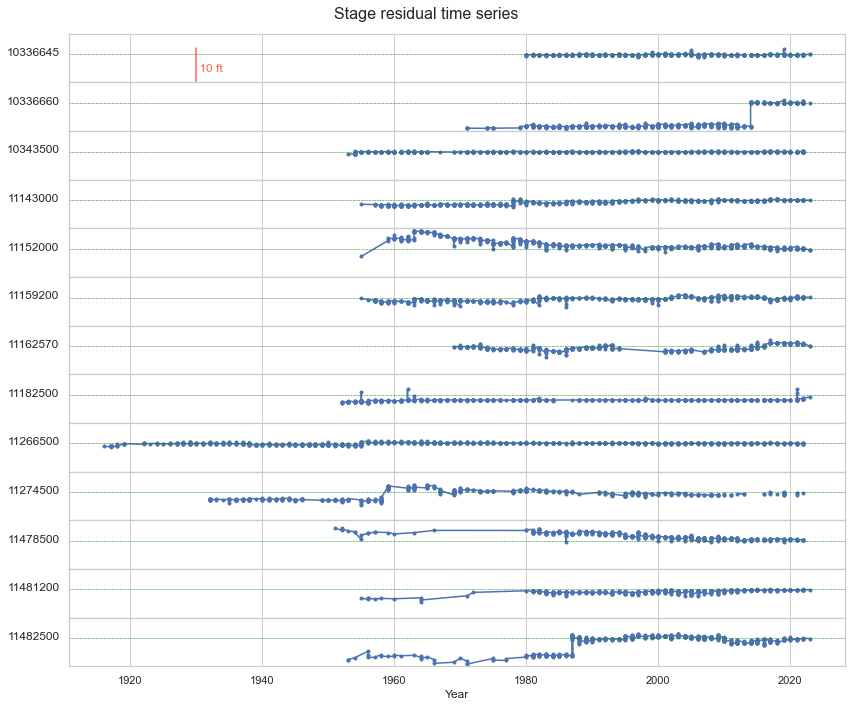

In [13]:
'''
    Plot the time series of all valid gauges in one plot for comparison.
    Each gauge is scaled in the range of a global max and min
(while calculating residuals for each gauge we update the max and min then set them as a limit for the plots).
'''

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(nrows=len(valid_siteno), ncols=1, figsize=(12, 10), sharex=True, gridspec_kw={'hspace': 0})
fig.suptitle("Stage residual time series", fontsize=16)
ymin = np.inf
ymax = -np.inf

for i, site_no in enumerate(valid_siteno):
    
        #Create subsets of data for each gauge and drop Na's
        site_df = field_measurements.loc[field_measurements['site_no'] == site_no]
        curve_df = curve.loc[curve['Site No'] == site_no]
        site_df.dropna(subset=["discharge_va", "gage_height_va"])
        curve_df.dropna(subset=["INDEP", "DEP"])

        stage_rating = curve_df["INDEP"].to_numpy()
        Q_rating = curve_df["DEP"].to_numpy()

        # Create boolean mask for increasing Q_rating
        q_diff = np.diff(Q_rating)
        q_mask = np.insert(q_diff, 0, Q_rating[0]) > 0

        # Filter arrays using boolean mask
        stage_rating_monot = stage_rating[q_mask]
        Q_rating_monot = Q_rating[q_mask]

        Q = site_df["discharge_va"].to_numpy()
        h_gage = site_df["gage_height_va"].to_numpy()
        
        #Interpolate rating curve's height and calculate residuals
        stage_rating_interp = np.interp(Q, Q_rating_monot, stage_rating_monot)
        stage_residual = h_gage - stage_rating_interp
        
        ymin = min(ymin, min(stage_residual))
        ymax = max(ymax, max(stage_residual))
        
        site_df["measurement_dt"].dt.normalize()
        year = site_df["measurement_dt"].dt.year
        
        axes[i].plot(year, stage_residual, ".-")

        axes[i].set_ylabel(str(site_no), rotation=0, labelpad=35)
        axes[i].set_yticks([])
        axes[i].axhline(y=0, color='green', linestyle='--', linewidth=0.5) #add y=0 axis
        
        # Add vertical measurement line to the first plot using the y max and min to calculate the position
        if i == len(valid_siteno) - 1:
            y_dist = 10
            yrange = ymax - ymin
            ymax_fraction = y_dist/yrange

            axes[0].axvline(x=1930, ymin=0, ymax=ymax_fraction, color='tomato', linestyle='-', linewidth=1.5)
            axes[0].text(1930, ymin+2, ' 10 ft', color='tomato', ha='left', va='bottom', rotation='horizontal', fontsize=12)
        
yrange = ymax - ymin
for ax in axes:
    ax.set_ylim(ymin - 0.05*yrange, ymax + 0.05*yrange)
    
# Set the x-label of the last subplot as the common x-axis label
axes[-1].set_xlabel("Year")

plt.tight_layout()
fig.savefig('Residual time series.jpg', dpi=300)

plt.show()

#### Residual time series plot for "maybe" gauges

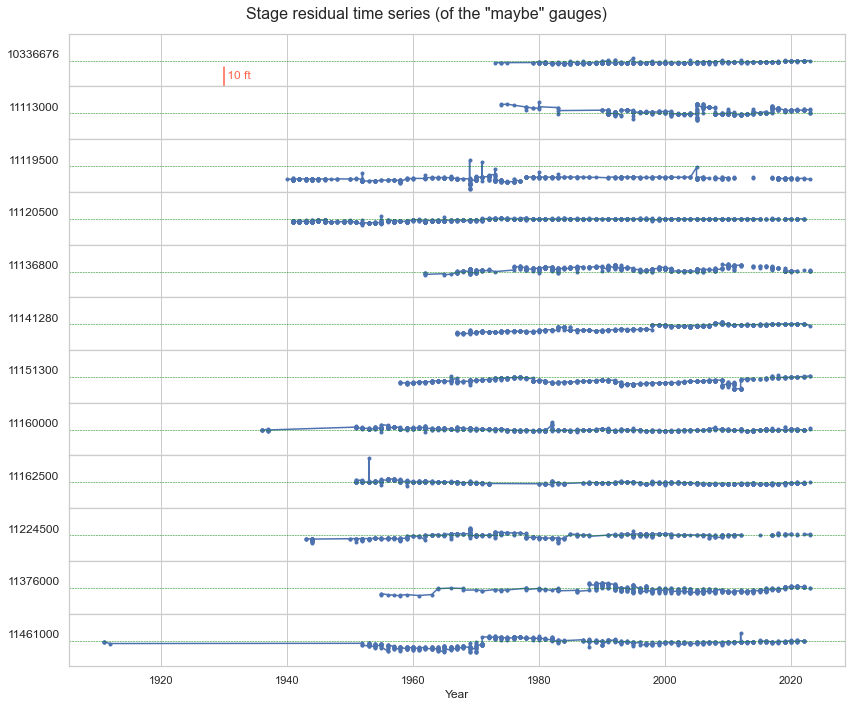

In [12]:
'''
    Plot the time series of all "maybe" gauges in one plot for comparison.
    Each gauge is scaled in the range of a global max and min
(while calculating residuals for each gauge we update the ymax and ymin then set them as a limit for the plots).
'''

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(nrows=len(maybe_siteno), ncols=1, figsize=(12, 10), sharex=True, gridspec_kw={'hspace': 0})
fig.suptitle("Stage residual time series (of the \"maybe\" gauges)", fontsize=16)
ymin = np.inf
ymax = -np.inf

for i, site_no in enumerate(maybe_siteno):
        
        #Create subsets of data for each gauge and drop Na's
        site_df = field_measurements.loc[field_measurements['site_no'] == site_no]
        curve_df = curve.loc[curve['Site No'] == site_no]
        site_df.dropna(subset=["discharge_va", "gage_height_va"])
        curve_df.dropna(subset=["INDEP", "DEP"])

        stage_rating = curve_df["INDEP"].to_numpy()
        Q_rating = curve_df["DEP"].to_numpy()

        # Create boolean mask for increasing Q_rating
        q_diff = np.diff(Q_rating)
        q_mask = np.insert(q_diff, 0, Q_rating[0]) > 0

        # Filter arrays using boolean mask
        stage_rating_monot = stage_rating[q_mask]
        Q_rating_monot = Q_rating[q_mask]

        Q = site_df["discharge_va"].to_numpy()
        h_gage = site_df["gage_height_va"].to_numpy()
        
        #Interpolate rating curve's height and calculate residuals
        stage_rating_interp = np.interp(Q, Q_rating_monot, stage_rating_monot)
        stage_residual = h_gage - stage_rating_interp
        
        ymin = min(ymin, min(stage_residual))
        ymax = max(ymax, max(stage_residual))
        
        site_df["measurement_dt"].dt.normalize()
        year = site_df["measurement_dt"].dt.year
        
        axes[i].plot(year, stage_residual, ".-")

        axes[i].set_ylabel(str(site_no), rotation=0, labelpad=35)
        axes[i].set_yticks([])
        axes[i].axhline(y=0, color='green', linestyle='--', linewidth=0.5) #add y=0 axis
        
        # Add vertical measurement line to the first plot using the y max and min to calculate the position
        if i == len(maybe_siteno) - 1:
            y_dist = 10
            yrange = ymax - ymin
            ymax_fraction = y_dist/yrange

            axes[0].axvline(x=1930, ymin=0, ymax=ymax_fraction, color='tomato', linestyle='-', linewidth=1.5)
            axes[0].text(1930, ymin+2, ' 10 ft', color='tomato', ha='left', va='bottom', rotation='horizontal', fontsize=12)
        
        
yrange = ymax - ymin
for ax in axes:
    ax.set_ylim(ymin - 0.05*yrange, ymax + 0.05*yrange)
    
# Set the x-label of the last subplot as the common x-axis label
axes[-1].set_xlabel("Year")

plt.tight_layout()
fig.savefig('Residual time series (maybe gauges).jpg', dpi=300)

plt.show()